# Environment

# Preparation

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.signal as signal
import csv
from IPython.display import Video

# Event Data

## Read data

In [55]:
def read_event_data(DATADIR, game_id):
    eventfile = f"/Sample_Game_{game_id}/Sample_Game_{game_id}_RawEventsData.csv"
    print(DATADIR+eventfile)
    events = pd.read_csv(DATADIR+eventfile)
    return events

In [56]:
DATADIR = "../sample-data/data"
events = read_event_data(DATADIR=DATADIR, game_id=2)
events.head()

../sample-data/data/Sample_Game_2/Sample_Game_2_RawEventsData.csv


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58


In [57]:
# count each event types
events["Type"].value_counts()

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

## Change coordinates

In [58]:
def to_metric_coordinates(data, field_dimen=(106., 68.)):
    x_columns = [c for c in data.columns if c[-1].lower()=="x"]
    y_columns = [c for c in data.columns if c[-1].lower()=="y"]
    data[x_columns] = ( data[x_columns]-0.5 ) * field_dimen[0]
    data[y_columns] = -1 * ( data[y_columns]-0.5 ) * field_dimen[1]
    return data

In [59]:
events = to_metric_coordinates(events)
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


## Check Goals

In [60]:
# Split events by team
home_events = events[events["Team"]=="Home"]
away_events = events[events["Team"]=="Away"]
print("HOME:")
print(home_events["Type"].value_counts())
print("\nAWAY:")
print(away_events["Type"].value_counts())

HOME:
PASS              543
CHALLENGE         160
RECOVERY          135
BALL LOST         120
SET PIECE          34
BALL OUT           27
SHOT               13
FAULT RECEIVED      9
CARD                3
Name: Type, dtype: int64

AWAY:
PASS              421
CHALLENGE         151
BALL LOST         113
RECOVERY          113
SET PIECE          46
BALL OUT           22
SHOT               11
FAULT RECEIVED     11
CARD                3
Name: Type, dtype: int64


In [61]:
# Identify shot from events
shots = events[events["Type"]=="SHOT"]
home_shots = home_events[home_events["Type"]=="SHOT"]
away_shots = away_events[away_events["Type"]=="SHOT"]
print("HOME SHOTS:")
print(home_shots["Subtype"].value_counts())
print("\nAWAY SHOTS:")
print(away_shots["Subtype"].value_counts())

HOME SHOTS:
ON TARGET-SAVED        4
HEAD-OFF TARGET-OUT    4
OFF TARGET-OUT         2
ON TARGET-GOAL         2
HEAD-ON TARGET-GOAL    1
Name: Subtype, dtype: int64

AWAY SHOTS:
OFF TARGET-OUT         3
BLOCKED                2
ON TARGET-GOAL         2
ON TARGET-SAVED        2
OFF TARGET-HEAD-OUT    1
HEAD-OFF TARGET-OUT    1
Name: Subtype, dtype: int64


In [62]:
# Identify shooted player
home_shots["From"].value_counts()

Player9     4
Player10    3
Player5     2
Player3     1
Player4     1
Player7     1
Player12    1
Name: From, dtype: int64

In [63]:
# Identify goal rows in events
home_goals = home_shots[home_shots["Subtype"].str.contains("-GOAL")].copy()
away_goals = away_shots[away_shots["Subtype"].str.contains("-GOAL")].copy()
home_goals["Minutes"] = home_goals["Start Time [s]"]/60
home_goals.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Minutes
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04,8.134667
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04,49.322000
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72,80.684667


## Plot plays

In [64]:
def plot_pitch(field_dimen = (106., 68.), field_color = "green", linewidth=2, markersize=20):
    fig, ax = plt.subplots(figsize=(12, 8))
    if field_color == "green":
        ax.set_facecolor("mediumseagreen")
        lc = "whitesmoke"
        pc = "w"
    elif field_color == "white":
        lc = "k"
        pc = "k"
    border_dimen = (3, 3)
    meters_per_yard = 0.9144
    half_pitch_length = field_dimen[0]/2.
    half_pitch_width = field_dimen[1]/2.
    signs = [-1, 1]
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    center_circle_radius = 10*meters_per_yard

    ax.plot([0, 0], [-half_pitch_width, half_pitch_width], lc, linewidth=linewidth)
    ax.scatter(0., 0., marker="o", facecolor=lc, linewidths=0, s=markersize)
    y = np.linspace(-1, 1, 50)*center_circle_radius
    x = np.sqrt(center_circle_radius**2-y**2)
    ax.plot(x, y, lc, linewidth=linewidth)
    ax.plot(-x, y, lc, linewidth=linewidth)
    for s in signs:
        ax.plot([-half_pitch_length, half_pitch_length], [s*half_pitch_width, s*half_pitch_width], lc, linewidth=linewidth)
        ax.plot([s*half_pitch_length, s*half_pitch_length], [-half_pitch_width, half_pitch_width], lc, linewidth=linewidth)

        ax.plot([s*half_pitch_length, s*half_pitch_length], [-goal_line_width/2., goal_line_width/2.], pc+"s", markersize=6*markersize/20., linewidth=linewidth)

        ax.plot([s*half_pitch_length, s*(half_pitch_length-box_length)], [box_width/2., box_width/2.], lc, linewidth=linewidth)
        ax.plot([s*half_pitch_length, s*(half_pitch_length-box_length)], [-box_width/2., -box_width/2.], lc, linewidth=linewidth)
        ax.plot([s*(half_pitch_length-box_length), s*(half_pitch_length-box_length)], [-box_width/2., box_width/2.], lc, linewidth=linewidth)

        ax.plot([s*half_pitch_length, s*(half_pitch_length-area_length)], [area_width/2., area_width/2.], lc, linewidth=linewidth)
        ax.plot([s*half_pitch_length, s*(half_pitch_length-area_length)], [-area_width/2., -area_width/2.], lc, linewidth=linewidth)
        ax.plot([s*(half_pitch_length-area_length), s*(half_pitch_length-area_length)], [-area_width/2., area_width/2.], lc, linewidth=linewidth)

        ax.scatter(s*(half_pitch_length-penalty_spot), 0.0, marker="o", facecolor=lc, linewidths=0, s=markersize)

        y = np.linspace(0, 1, 50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*(half_pitch_length-x), -half_pitch_width+y, lc, linewidth=linewidth)
        ax.plot(s*(half_pitch_length-x), half_pitch_width-y, lc, linewidth=linewidth)

        y = np.linspace(-1, 1, 50)*D_length
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*(half_pitch_length-x), y, lc, linewidth=linewidth)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax, xmax])
    ax.set_ylim([-ymax, ymax])
    ax.set_axisbelow(True)
    return fig, ax

Text(-47.7, -3.400000000000003, '')

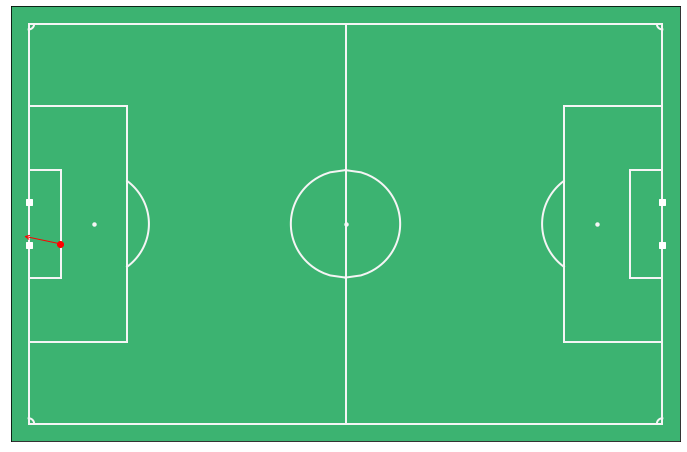

In [65]:
# plot first goal
fig,ax = plot_pitch()
ax.plot(events.loc[198]["Start X"], events.loc[198]["Start Y"], "ro")
ax.annotate("", xy=events.loc[198][["End X", "End Y"]], xytext=events.loc[198][["Start X", "Start Y"]], alpha=0.6, arrowprops=dict(arrowstyle="->", color="r"))

In [66]:
def plot_events(events, figax = None, field_dimen = (106., 68.), indicators = ["Marker", "Arrow"], color="r", marker_style="o", alpha=0.5, annotate=False):
    if figax is None:
        fig, ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig, ax = figax
    for i, row in events.iterrows():
        if "Marker" in indicators:
            ax.plot(row["Start X"], row["Start Y"], color+marker_style, alpha=alpha)
        if "Arrow" in indicators:
            ax.annotate("", xy=row[["End X", "End Y"]], xytext=row[["Start X", "Start Y"]], alpha=alpha, arrowprops=dict(alpha=alpha, width=0.5, headlength=4.0, headwidth=4.0, color=color), annotation_clip=False)
        if annotate:
            textstring = row["Type"] + ": " + row["From"]
            ax.text(row["Start X"], row["Start Y"], textstring, fontsize=10, color=color)
    return fig, ax

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

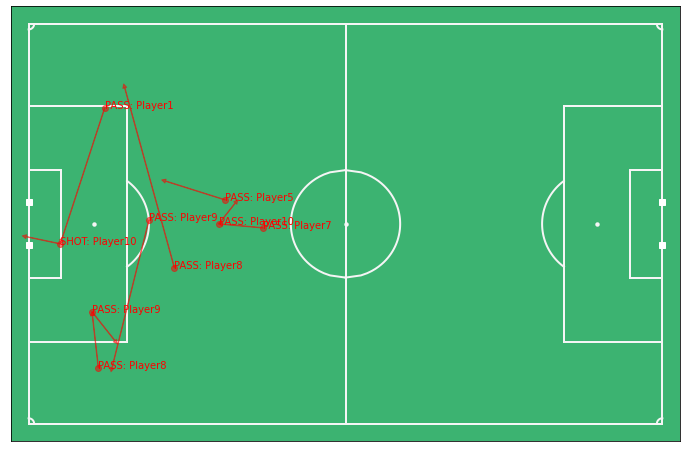

In [67]:
# plot path to first goal
plot_events(events.loc[190:198], indicators=["Marker", "Arrow"], annotate=True)

# Tracking Data

## Read Data

In [68]:
def tracking_data(DATADIR, game_id, teamname):
    teamfile=f"/Sample_Game_{game_id}/Sample_Game_{game_id}_RawTrackingData_{teamname}_Team.csv"
    csvfile = open(DATADIR+teamfile, "r")
    reader = csv.reader(csvfile)
    teamnamefull = next(reader)[3].lower()
    print(f"Reading team: {teamnamefull}")

    jerseys = [x for x in next(reader) if x != ""]
    columns = next(reader)
    for i, j in enumerate(jerseys):
        columns[i*2+3] = f"{teamname}_{j}_x"
        columns[i*2+4] = f"{teamname}_{j}_y"
    columns[-2] = "ball_x"
    columns[-1] = "ball_y"
    tracking = pd.read_csv(DATADIR+teamfile, names=columns, index_col="Frame", skiprows=3)
    return tracking

In [69]:
DATADIR = "../sample-data/data"
tracking_home = tracking_data(DATADIR=DATADIR, game_id=2, teamname="Home")
tracking_away = tracking_data(DATADIR=DATADIR, game_id=2, teamname="Away")
print(tracking_home.columns)
tracking_home.head()

Reading team: home
Reading team: away
Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')


,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Change Coordinates

In [70]:
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)
tracking_home.head()


,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.20564,-7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot Plays

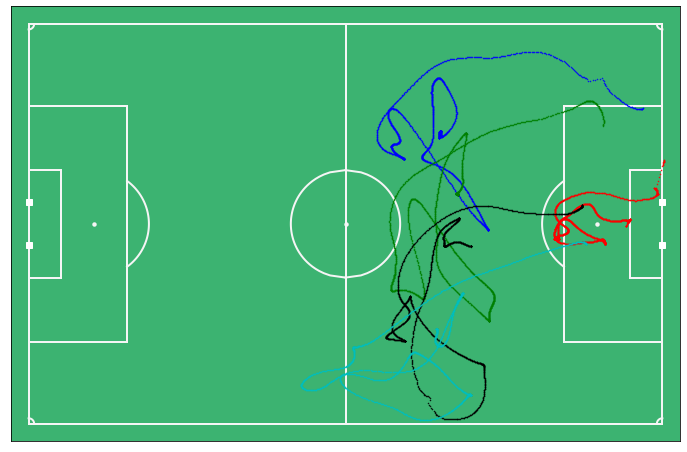

In [71]:
# plot trajectories
fig, ax = plot_pitch()
ax.plot(tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', markersize=1)
ax.plot(tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', markersize=1)
ax.plot(tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', markersize=1)
ax.plot(tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'k.', markersize=1)
ax.plot(tracking_home['Home_4_x'].iloc[:1500], tracking_home['Home_4_y'].iloc[:1500], 'c.', markersize=1)

In [72]:
def plot_frame(hometeam, awayteam, figax=None, team_colors=("r", "b"), field_dimen=(106., 68.), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False):
    if figax is None:
        fig, ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig, ax = figax
    for team, color in zip([hometeam, awayteam], team_colors):
        x_columns = [c for c in team.keys() if c[-2:].lower()=="_x" and c!="ball_x"]
        y_columns = [c for c in team.keys() if c[-2:].lower()=="_y" and c!="ball_y"]
        ax.plot(team[x_columns], team[y_columns], color+"o", markersize=PlayerMarkerSize, alpha=PlayerAlpha)
        if include_player_velocities:
            vx_columns = [f"{c[:-2]}_vx" for c in x_columns]
            vy_columns = [f"{c[:-2]}_vy" for c in y_columns]
            ax.quiver(team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units="inches", scale=10., width=0.0015, headlength=5, headwidth=3, alpha=PlayerAlpha)
        if annotate:
            [ax.text(team[x]+0.5, team[y]+0.5, x.split("_")[1], fontsize=10, color=color) for x, y in zip(x_columns, y_columns) if not (np.isnan(team[x]) or np.isnan(team[y]))]
    ax.plot(hometeam["ball_x"], hometeam["ball_y"], "ko", markersize=6, alpha=1.0, linewidth=0)
    return fig, ax

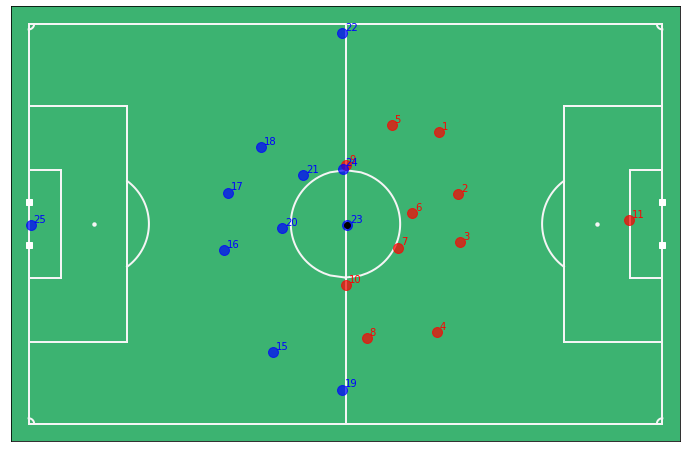

In [73]:
# plot frame
KO_Frame = events.loc[0]["Start Frame"]
fig, ax = plot_frame(tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame], annotate=True)

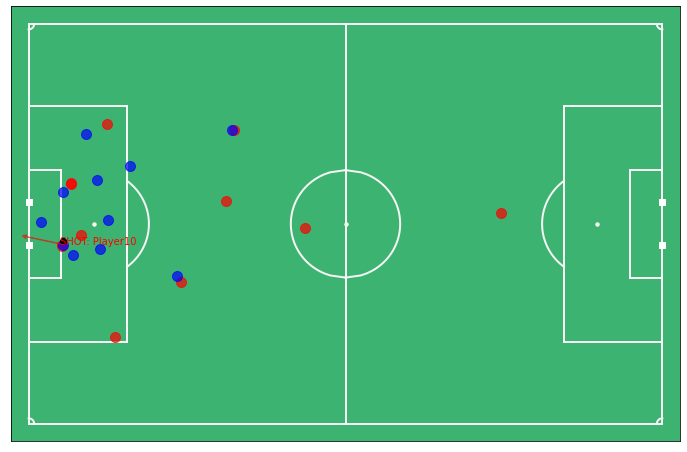

In [74]:
fig, ax = plot_events(events.loc[198:198], indicators=["Marker", "Arrow"], annotate=True)
goal_frame = events.loc[198]["Start Frame"]
fig, ax = plot_frame(tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax=(fig, ax))

In [75]:
events.loc[198]

Team                        Home
Type                        SHOT
Subtype           ON TARGET-GOAL
Period                         1
Start Frame                12202
Start Time [s]            488.08
End Frame                  12212
End Time [s]              488.48
From                    Player10
To                           NaN
Start X                    -47.7
Start Y                     -3.4
End X                     -54.06
End Y                      -2.04
Name: 198, dtype: object

## Reverse Direction for 2nd Half

In [76]:
def to_single_playing_direction(home, away, events):
    for team in [home, away, events]:
        second_half_idx = team.Period.idxmax()
        columns = [c for c in team.columns if c[-1].lower() in ["x", "y"]]
        team.loc[second_half_idx:, columns] *= -1
    return home, away, events

In [77]:
# reverse direction for 2nd half
tracking_home, tracking_away, events = to_single_playing_direction(tracking_home, tracking_away, events)

## Making Movie

In [78]:
def save_match_clip(hometeam, awayteam, fpath, fname="clip_test", figax=None, frames_per_second=25, team_colors=("r", "b"), field_dimen=(106., 68.), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7):
    assert np.all(hometeam.index==awayteam.index), "Home and away team Dataframe indices must be the same"
    index = hometeam.index
    # FFMpegWriter = animation.FFMpegWriter()
    metadata = dict(title="Tracking Data", artist="Matplotlib", comment="Data clip")
    writer = animation.FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + "/" + fname + ".mp4"
    print(fname)
    if figax is None:
        fig, ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig, ax = figax
    fig.set_tight_layout(True)
    print("Generating movie...", end="")
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = []
            for team, color in zip([hometeam.loc[i], awayteam.loc[i]], team_colors):
                x_columns = [c for c in team.keys() if c[-2:].lower()=="_x" and c!="ball_x"]
                y_columns = [c for c in team.keys() if c[-2:].lower()=="_y" and c!="ball_y"]
                objs, = ax.plot(team[x_columns], team[y_columns], color+"o", markersize=PlayerMarkerSize, alpha=PlayerAlpha)
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = [f"{c[:-2]}_vx" for c in x_columns]
                    vy_columns = [f"{c[:-2]}_vy" for c in y_columns]
                    objs = ax.quiver(team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units="inches", scale=10., width=0.0015, headlength=5, headwidth=3, alpha=PlayerAlpha)
                    figobjs.append(objs)
            objs, = ax.plot(team["ball_x"], team["ball_y"], "ko", markersize=6, alpha=1.0, linewidth=0)
            figobjs.append(objs)
            frame_minute = int(team["Time [s]"]/60.)
            frame_second = (team["Time [s]"]/60.-frame_minute)*60.
            timestring = f"{frame_minute}:{frame_second:1.2f}"
            objs = ax.text(-2.5, field_dimen[1]/2.+1., timestring, fontsize=14)
            figobjs.append(objs)
            writer.grab_frame()
            for figobj in figobjs:
                figobj.remove()
            figobjs = []
    print("done")
    plt.clf()
    plt.close(fig)

In [79]:
# plot movie
PLOTDIR = "../output"
save_match_clip(tracking_home.iloc[73600:73600+500], tracking_away[73600:73600+500], PLOTDIR, fname="home_goal_2", include_player_velocities=False)
Video(data="../output/home_goal_2.mp4")

../output/home_goal_2.mp4
Generating movie...done


## Calculate Velocity

In [80]:
def remove_player_velocities(team):
    columns = [c for c in team.columns if c.split("_")[-1] in ["vx", "vy", "ax", "ay", "speed", "acceleration"]]
    team = team.drop(columns=columns)
    return team

def calc_player_velocities(team, smoothing=True, filter="Savitzky-Golay", window=7, polyorder=1, maxspeed=12):
    team = remove_player_velocities(team)
    player_ids = np.unique([c[:-2] for c in team.columns if c[:4] in ["Home", "Away"]])
    dt = team["Time [s]"].diff()
    second_half_idx = team.Period.idxmax()
    for player in player_ids:
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt
        if maxspeed > 0:
            raw_speed = np.sqrt(vx**2 + vy**2)
            vx[raw_speed > maxspeed] = np.nan
            vy[raw_speed > maxspeed] = np.nan
        if smoothing:
            if filter=="Savitzky-Golay":
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx], window_length=window, polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx], window_length=window, polyorder=polyorder)
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:], window_length=window, polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:], window_length=window, polyorder=polyorder)
            elif filter=="moving average":
                ma_window = np.ones(window) / window
                vx.loc[:second_half_idx] = np.convolve(vx.loc[:second_half_idx], ma_window, mode="same")
                vy.loc[:second_half_idx] = np.convolve(vy.loc[:second_half_idx], ma_window, mode="same")
                vx.loc[second_half_idx:] = np.convolve(vx.loc[second_half_idx:], ma_window, mode="same")
                vy.loc[second_half_idx:] = np.convolve(vy.loc[second_half_idx:], ma_window, mode="same")
        team[player+"_vx"] = vx
        team[player+"_vy"] = vy
        team[player+"_speed"] = np.sqrt(vx**2 + vy**2)
    return team

In [81]:
# calculate velocities
tracking_home = calc_player_velocities(tracking_home, smoothing=True)
tracking_away = calc_player_velocities(tracking_away, smoothing=True)
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

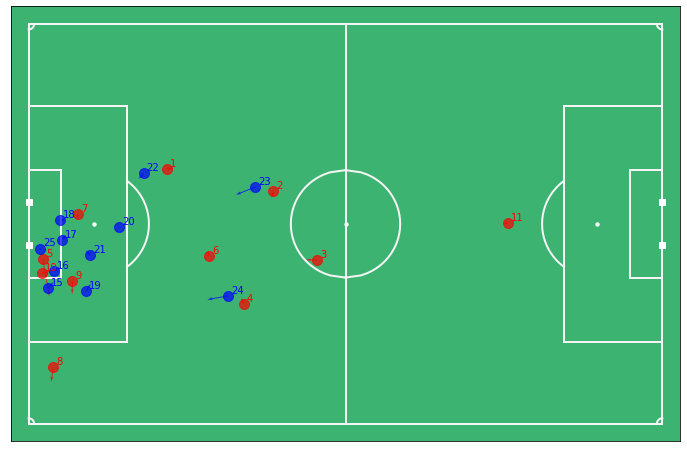

In [82]:
plot_frame(tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)

# Summary for players

In [83]:
# create datafreme for home players
home_players = np.unique([c.split("_")[1] for c in tracking_home.columns if c[:4] == "Home"])
home_summary = pd.DataFrame(index=home_players)

Text(0, 0.5, 'Dostance covered [km]')

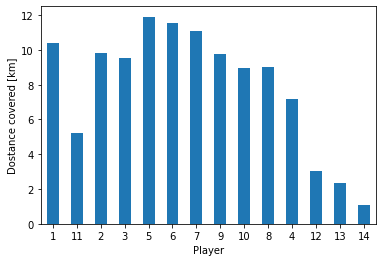

In [84]:
# calculate played minutes
minutes = []
for player in home_players:
    column = "Home_" + player + "_x"
    player_minutes = (tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1) / 25 / 60.
    minutes.append(player_minutes)
home_summary["Minutes Played"] = minutes
home_summary = home_summary.sort_values(["Minutes Played"], ascending=False)

# calculate total distances
distance = []
for player in home_summary.index:
    column = "Home_" + player + "_speed"
    player_distance = tracking_home[column].sum()/25./1000
    distance.append(player_distance)
home_summary["Distance [km]"] = distance

plt.subplots()
ax = home_summary["Distance [km]"].plot.bar(rot=0)
ax.set_xlabel("Player")
ax.set_ylabel("Dostance covered [km]")

In [85]:
# calculate walking / jogging / running / sprinting distance
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = "Home_" + player + "_speed"
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append(player_distance)
    player_distance = tracking_home.loc[(tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append(player_distance)
    player_distance = tracking_home.loc[(tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append(player_distance)
    player_distance = tracking_home.loc[tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append(player_distance)
home_summary["Walking [km]"] = walking
home_summary["Jogging [km]"] = jogging
home_summary["Running [km]"] = running
home_summary["Sprinting [km]"] = sprinting

In [86]:
# sprinting times
nsprints = []
sprint_threshold = 7
sprint_window = 1*25
for player in home_summary.index:
    column = "Home_" + player + "_speed"
    player_sprints = np.diff(1*(np.convolve(1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode="same") >= sprint_window))
    nsprints.append(np.sum(player_sprints==1))
home_summary["# sprints"] = nsprints
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],# sprints
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712,5
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718,0
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811,3
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166,8
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669,8
6,94.104000,11.535969,3.385553,5.145440,2.829522,0.175454,7
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470,9
9,94.104000,9.765283,4.428139,3.322470,1.863521,0.151153,7
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760,13
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051,6


## Plot sprints

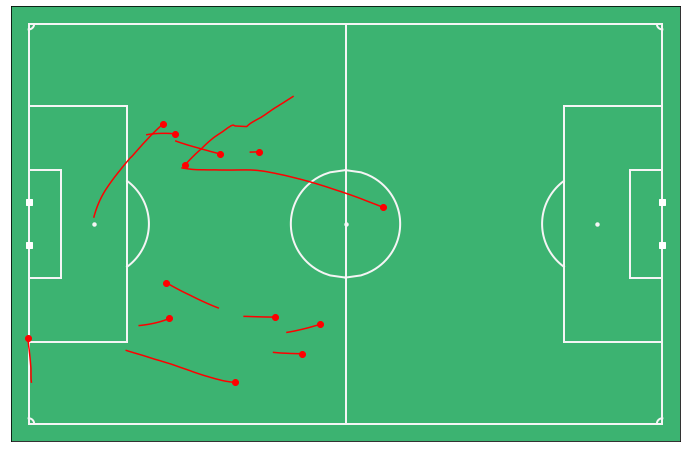

In [87]:
player = "10"
column = "Home_" + player + "_speed"
column_x = "Home_" + player + "_x"
column_y = "Home_" + player + "_y"
player_sprints = np.diff(1*(np.convolve(1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode="same") >= sprint_window))
player_sprints_start = np.where(player_sprints==1)[0] - int(sprint_window/2) + 1
player_sprints_end = np.where(player_sprints==-1)[0] - int(sprint_window/2) + 1
fig, ax = plot_pitch()
for s, e in zip(player_sprints_start, player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s], tracking_home[column_y].iloc[s], "ro")
    ax.plot(tracking_home[column_x].iloc[s:e+1], tracking_home[column_y].iloc[s:e+1], "r")

# Pitch Control

In [88]:
shots = events[events["Type"]=="SHOT"]
goals = shots[shots["Subtype"].str.contains("-GOAL")].copy()
goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,-47.70,1.36,-54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,40.28,1.36,55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,-30.74,5.44,-54.06,2.72


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

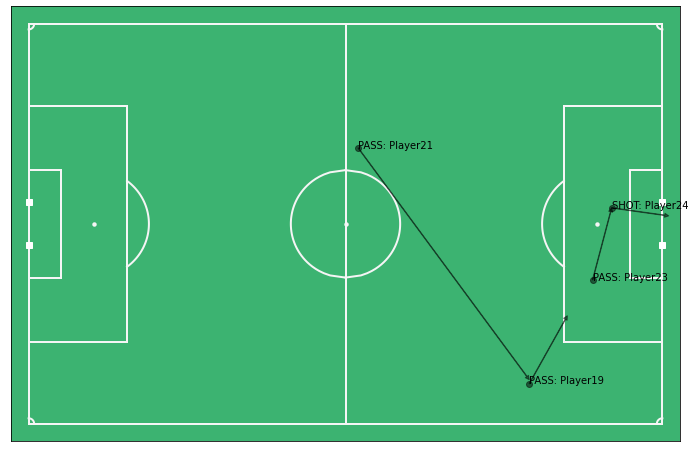

In [89]:
plot_events(events.loc[820:823], color="k", indicators=["Marker", "Arrow"], annotate=True)

In [90]:
def default_model_params(time_to_control_veto=3):
    params = {}
    params["max_player_accel"] = 7.
    params["max_player_speed"] = 5.
    params["reaction_time"] = 0.7
    params["tti_sigma"] = 0.45
    params["kappa_def"] = 1.
    params["lambda_att"] = 4.3
    params["lambda_def"] = 4.3 * params["kappa_def"]
    params["lambda_gk"] = params["lambda_def"]*3.0
    params["average_ball_speed"] = 15.
    params["int_dt"] = 0.04
    params["max_int_time"] = 10
    params["model_converge_tol"] = 0.01
    params["time_to_control_att"] = time_to_control_veto*np.log(10)*(np.sqrt(3)*params["tti_sigma"]/np.pi + 1/params["lambda_att"])
    params["time_to_control_def"] = time_to_control_veto*np.log(10)*(np.sqrt(3)*params["tti_sigma"]/np.pi + 1/params["lambda_def"])
    return params

def find_goalkeepers(team):
    x_columns = [c for c in team.columns if c[-2:].lower()=="_x" and c[:4] in ["Home", "Away"]]
    GK_col = team.iloc[0][x_columns].abs().idxmax()
    return GK_col.split("_")[1]

params = default_model_params()
GK_numbers = [find_goalkeepers(tracking_home), find_goalkeepers(tracking_away)]

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

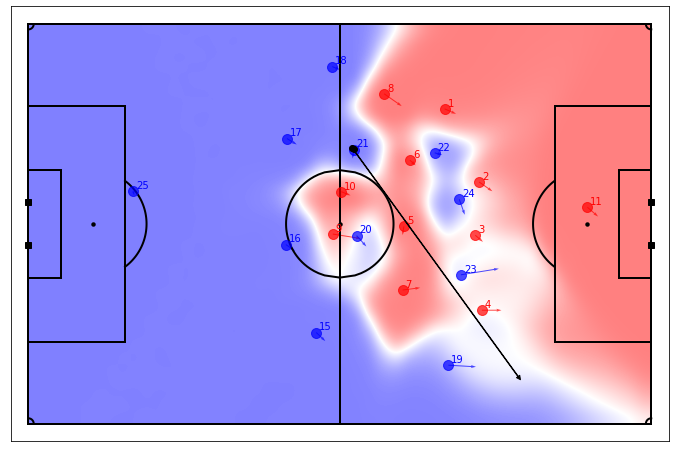

In [91]:
class player(object):
    def __init__(self, pid, team, teamname, params, GKid):
        self.id = pid
        self.is_gk = (self.id == GKid)
        self.teamname = teamname
        self.playername = f"{teamname}_{pid}_"
        self.vmax = params["max_player_speed"]
        self.reaction_time = params["reaction_time"]
        self.tti_sigma = params["tti_sigma"]
        self.lambda_att = params["lambda_att"]
        self.lambda_def = params["lambda_gk"] if self.is_gk else params["lambda_def"]
        self.get_position(team)
        self.get_velocity(team)
        self.PPCF = 0.

    def get_position(self, team):
        self.position = np.array([team[self.playername+"x"], team[self.playername+"y"]])
        self.inframe = not np.any(np.isnan(self.position))

    def get_velocity(self, team):
        self.velocity = np.array([team[self.playername+"vx"], team[self.playername+"vy"]])
        if np.any(np.isnan(self.velocity)):
            self.velocity = np.array([0., 0.])

    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept

    def probability_intercept_ball(self, T):
        f = 1/(1. + np.exp(-np.pi/np.sqrt(3.0)/self.tti_sigma*(T-self.time_to_intercept)))
        return f


def initialise_players(team, teamname, params, GKid):
    player_ids = np.unique([c.split("_")[1] for c in team.keys() if c[:4] == teamname])
    team_players = []
    for p in player_ids:
        team_player = player(p, team, teamname, params, GKid)
        if team_player.inframe:
            team_players.append(team_player)
    return team_players


def check_offsides(attacking_players, defending_players, ball_position, GK_numbers, verbose=False, tol=0.2):
    defending_GK_id = GK_numbers[1] if attacking_players[0].teamname=="Home" else GK_numbers[0]
    assert defending_GK_id in [p.id for p in defending_players], "defending goalkeeper jersey number not found in defending players"
    defending_GK = [p for p in defending_players if p.id==defending_GK_id][0]
    defending_half = np.sign(defending_GK.position[0])
    second_deepest_defender_x = sorted([defending_half*p.position[0] for p in defending_players], reverse=True)[1]
    offside_line = max(second_deepest_defender_x, defending_half*ball_position[0], 0.0) + tol
    if verbose:
        for p in attacking_players:
            if p.position[0]*defending_half > offside_line:
                print(f"player {p.id} in {p.playername} team is offside")
    attacking_players = [p for p in attacking_players if p.position[0]*defending_half <=offside_line]
    return attacking_players


def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    if ball_start_pos is None or any(np.isnan(ball_start_pos)):
        ball_travel_time = 0.0
    else:
        ball_travel_time = np.linalg.norm(target_position - ball_start_pos)/params["average_ball_speed"]
    tau_min_att = np.nanmin([p.simple_time_to_intercept(target_position) for p in attacking_players])
    tau_min_def = np.nanmin([p.simple_time_to_intercept(target_position) for p in defending_players])
    if tau_min_att - max(ball_travel_time, tau_min_def) >= params["time_to_control_def"]:
        return 0., 1.
    elif tau_min_def - max(ball_travel_time, tau_min_att) >= params["time_to_control_att"]:
        return 1., 0.
    else:
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params["time_to_control_att"]]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params["time_to_control_def"]]
        dT_array = np.arange(ball_travel_time-params["int_dt"], ball_travel_time+params["max_int_time"], params["int_dt"])
        PPCFatt = np.zeros_like(dT_array)
        PPCFdef = np.zeros_like(dT_array)
        ptot = 0.0
        i = 1
        while 1-ptot > params["model_converge_tol"] and i < dT_array.size:
            T = dT_array[i]
            for player in attacking_players:
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball(T)*player.lambda_att
                assert dPPCFdT >= 0, "Invalid attacking player probability (calculate_pitch_control_at_target)"
                player.PPCF += dPPCFdT*params["int_dt"]
                PPCFatt[i] += player.PPCF
            for player in defending_players:
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball(T)*player.lambda_def
                assert dPPCFdT >= 0, "Invalid defending player probability (calculate_pitch_control_at_target)"
                player.PPCF += dPPCFdT*params["int_dt"]
                PPCFdef[i] += player.PPCF
            ptot = PPCFdef[i] + PPCFatt[i]
            i += 1
        if i >= dT_array.size:
            print(f"Integration failed to converge: {ptot:1.3f}")
        return PPCFatt[i-1], PPCFdef[i-1]

def generate_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50, offsides=True):
    pass_frame = events.loc[event_id]["Start Frame"]
    pass_team = events.loc[event_id].Team
    ball_start_pos = np.array([events.loc[event_id]["Start X"], events.loc[event_id]["Start Y"]])
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
    PPCFa = np.zeros(shape=(len(ygrid), len(xgrid)))
    PPCFd = np.zeros(shape=(len(ygrid), len(xgrid)))
    if pass_team=="Home":
        attacking_players = initialise_players(tracking_home.loc[pass_frame], "Home", params, GK_numbers[0])
        defending_players = initialise_players(tracking_away.loc[pass_frame], "Away", params, GK_numbers[1])
    elif pass_team=="Away":
        defending_players = initialise_players(tracking_home.loc[pass_frame], "Home", params, GK_numbers[0])
        attacking_players = initialise_players(tracking_away.loc[pass_frame], "Away", params, GK_numbers[1])
    else:
        assert False, "Team in possession must be either home or away"
    if offsides:
        attacking_players = check_offsides(attacking_players, defending_players, ball_start_pos, GK_numbers)
    for i in range(len(ygrid)):
        for j in range(len(xgrid)):
            target_position = np.array([xgrid[j], ygrid[i]])
            PPCFa[i, j], PPCFd[i, j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
    checksum = np.sum(PPCFa + PPCFd) / float(n_grid_cells_y*n_grid_cells_x)
    assert 1-checksum < params["model_converge_tol"], f"Checksum failed: {(1-checksum):1.3f}"
    return PPCFa,xgrid,ygrid

def plot_pitchcontrol_for_event(event_id, events, tracking_home, tracking_away, PPCF, alpha=0.7, include_player_velocities=True, annotate=False, field_dimen=(106., 68.)):
    pass_frame = events.loc[event_id]["Start Frame"]
    pass_team = events.loc[event_id].Team
    fig, ax = plot_pitch(field_color="white", field_dimen=field_dimen)
    plot_frame(tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=(fig, ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate)
    plot_events(events.loc[event_id:event_id], figax=(fig, ax), indicators=["Marker", "Arrow"], annotate=False, color="k", alpha=1)
    if pass_team=="Home":
        cmap = "bwr"
    else:
        cmap = "bwr_r"
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.), interpolation="spline36", vmin=0.0, vmax=1.0, cmap=cmap, alpha=0.5)
    return fig, ax

PPCF, xgrid, ygrid = generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50)
plot_pitchcontrol_for_event(820, events, tracking_home, tracking_away, PPCF, annotate=True)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

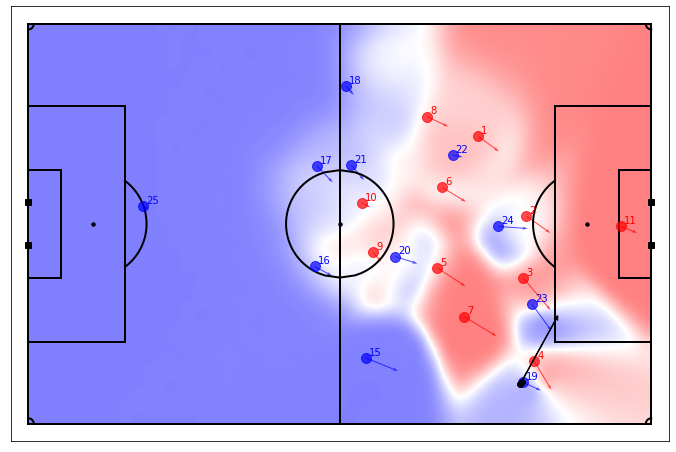

In [92]:
PPCF, xgrid, ygrid = generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50)
plot_pitchcontrol_for_event(821, events, tracking_home, tracking_away, PPCF, annotate=True)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

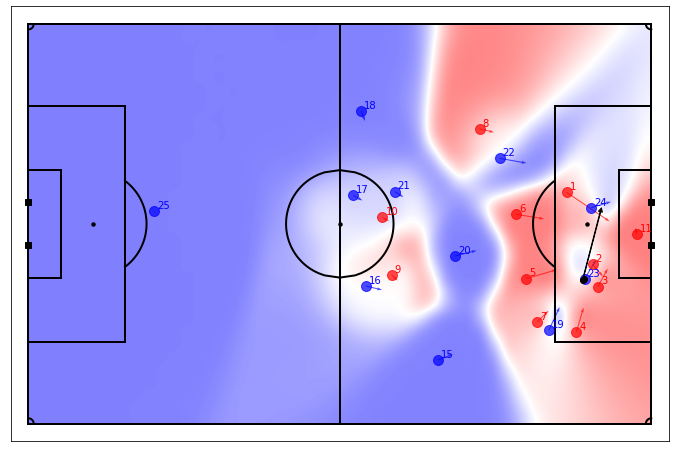

In [93]:
PPCF, xgrid, ygrid = generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50)
plot_pitchcontrol_for_event(822, events, tracking_home, tracking_away, PPCF, annotate=True)


## Caluclate Pass probability

Text(0, 0.5, 'Frequency')

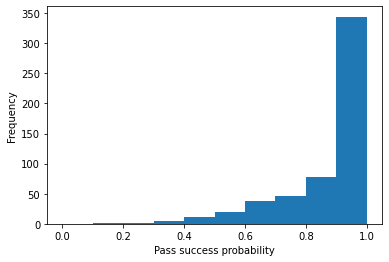

In [94]:
home_passes = events[(events["Type"].isin(["PASS"]))&(events["Team"]=="Home")]
pass_success_probability = []
for i, row in home_passes.iterrows():
    pass_start_pos = np.array([row["Start X"], row["Start Y"]])
    pass_target_pos = np.array([row["End X"], row["End Y"]])
    pass_frame = row["Start Frame"]
    attacking_players = initialise_players(tracking_home.loc[pass_frame], "Home", params, GK_numbers[0])
    defending_players = initialise_players(tracking_away.loc[pass_frame], "Away", params, GK_numbers[1])
    Patt, Pdef = calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)
    pass_success_probability.append((i, Patt))

fig, ax = plt.subplots()
ax.hist([p[1] for p in pass_success_probability], np.arange(0, 1.1, 0.1))
ax.set_xlabel("Pass success probability")
ax.set_ylabel("Frequency")

## plot risky pass

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

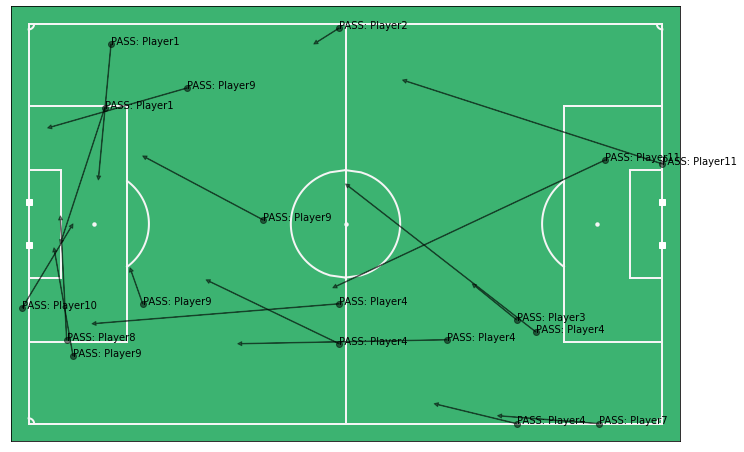

In [95]:
pass_success_probability = sorted(pass_success_probability, key=lambda x: x[1])
risky_passes = events.loc[[p[0] for p in pass_success_probability if p[1]<0.5]]
plot_events(risky_passes, color="k", indicators=["Marker", "Arrow"], annotate=True)

In [96]:
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[p[0]+1].Type
    print(p[1], outcome)

Event following a risky (completed) pass
0.16032323299177284 BALL LOST
0.1613295457364337 CHALLENGE
0.21206157666402695 SHOT
0.31160841865474675 CHALLENGE
0.33190526185319935 SHOT
0.3370434729809066 CHALLENGE
0.3639283907689767 BALL LOST
0.4131562523163675 CHALLENGE
0.42042677463419303 PASS
0.431271262852387 CHALLENGE
0.44435098489184177 CHALLENGE
0.4484489555199405 PASS
0.45936651514837745 CHALLENGE
0.46181533356257215 SHOT
0.4680481708799845 CHALLENGE
0.48972755639125787 CHALLENGE
0.49008726464957086 CHALLENGE
0.4917205100922201 SHOT
0.5001349056944226 PASS
0.5026909720011076 PASS


## Measure Expected Posession Value(EPV)

In [97]:
def find_playing_direction(team, teamname):
    GK_Column_x = teamname + "_" + find_goalkeepers(team) + "_x"
    return -np.sign(team.iloc[0][GK_Column_x])


home_attacking_direction = find_playing_direction(tracking_home, "Home")
print(home_attacking_direction)

-1.0


In [98]:
def load_EPV_grid(fname="EPV_grid.csv"):
    epv = np.loadtxt(fname, delimiter=",")
    return epv

EPVDIR = "../LaurieOnTracking"
EPV = load_EPV_grid(EPVDIR + "/EPV_grid.csv")

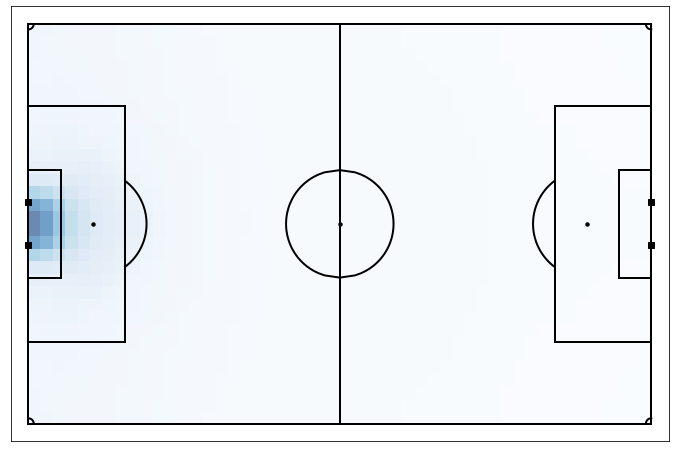

In [99]:
def plot_EPV(EPV, field_dimen=(106., 68.), attack_direction=1):
    if attack_direction==-1:
        EPV = np.fliplr(EPV)
    ny, nx = EPV.shape
    fig, ax = plot_pitch(field_color="white", field_dimen=field_dimen)
    ax.imshow(EPV, extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.), vmin=0.0, vmax=0.6, cmap="Blues", alpha=0.6)

plot_EPV(EPV, field_dimen=(106., 68.), attack_direction=home_attacking_direction)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

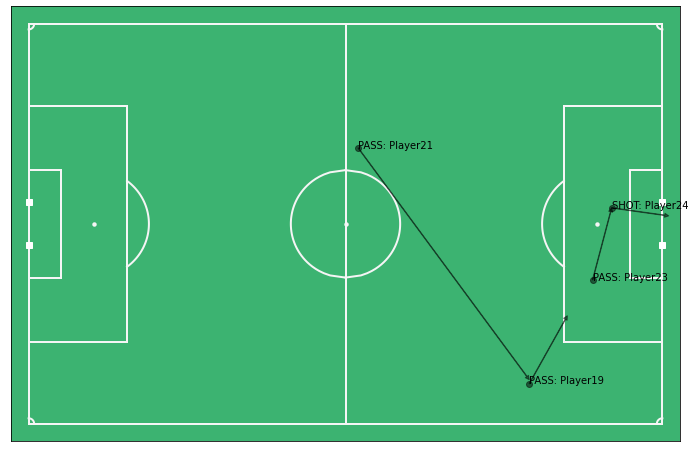

In [100]:
plot_events(events.loc[820:823], color="k", indicators=["Marker", "Arrow"], annotate=True)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

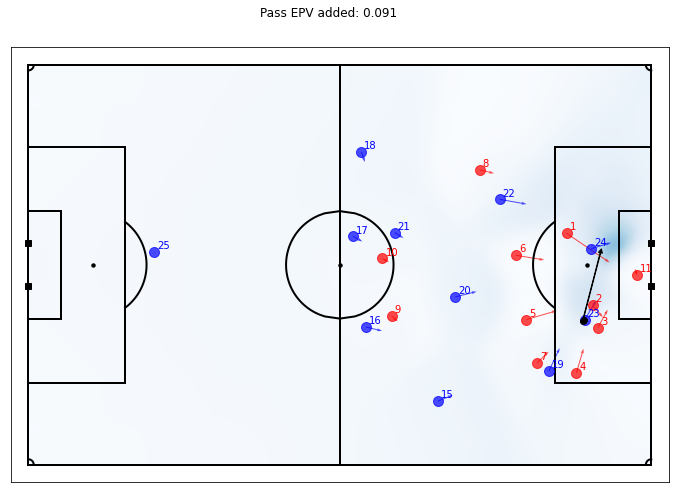

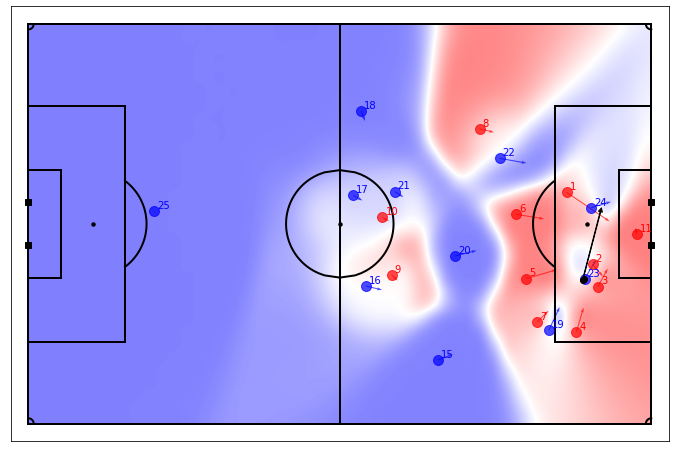

In [101]:
def get_EPV_at_location(position, EPV, attack_direction, field_dimen=(106., 68.)):
    x, y = position
    if abs(x) > field_dimen[0]/2. or abs(y) > field_dimen[1]/2.:
        return 0.0
    else:
        if attack_direction==-1:
            EPV = np.fliplr(EPV)
        ny, nx = EPV.shape
        dx = field_dimen[0]/float(nx)
        dy = field_dimen[1]/float(ny)
        ix = (x + field_dimen[0]/2.-0.0001)/dx
        iy = (y + field_dimen[1]/2.-0.0001)/dy
        return EPV[int(iy), int(ix)]

def calculate_epv_added(event_id, events, tracking_home, tracking_away, GK_numbers, EPV, params):
    pass_start_pos = np.array([events.loc[event_id]["Start X"], events.loc[event_id]["Start Y"]])
    pass_target_pos = np.array([events.loc[event_id]["End X"], events.loc[event_id]["End Y"]])
    pass_frame = events.loc[event_id]["Start Frame"]
    pass_team = events.loc[event_id].Team
    home_attacking_direction = find_playing_direction(tracking_home, "Home")
    if pass_team=="Home":
        attack_direction = home_attacking_direction
        attacking_players = initialise_players(tracking_home.loc[pass_frame], "Home", params, GK_numbers[0])
        defending_players = initialise_players(tracking_away.loc[pass_frame], "Away", params, GK_numbers[1])
    elif pass_team=="Away":
        attack_direction = -1 * home_attacking_direction
        defending_players = initialise_players(tracking_home.loc[pass_frame], "Home", params, GK_numbers[0])
        attacking_players = initialise_players(tracking_away.loc[pass_frame], "Away", params, GK_numbers[1])
    attacking_players = check_offsides(attacking_players, defending_players, pass_start_pos, GK_numbers)
    Patt_start, _ = calculate_pitch_control_at_target(pass_start_pos, attacking_players, defending_players, pass_start_pos, params)
    Patt_target, _ = calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)
    EPV_start = get_EPV_at_location(pass_start_pos, EPV, attack_direction=attack_direction)
    PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50, offsides=True)
    if attack_direction == -1:
        EEPV = np.fliplr(EPV)*PPCF
    else:
        EEPV = EPV*PPCF
    maxEPV_idx = np.unravel_index(EEPV.argmax(), EEPV.shape)
    EEPV_start = Patt_start*EPV_start
    maxEPV_added = EEPV.max() - EEPV_start
    max_target_location = (xgrid[maxEPV_idx[1]], ygrid[maxEPV_idx[0]])
    return maxEPV_added, max_target_location


def plot_EPV_for_event(event_id, events, tracking_home, tracking_away, PPCF, EPV, alpha=0.7, include_player_velocities=True, annotate=False, autoscale=0.1, contours=False, field_dimen=(106., 68.)):
    pass_frame = events.loc[event_id]["Start Frame"]
    pass_team = events.loc[event_id].Team
    fig, ax = plot_pitch(field_color="white", field_dimen=field_dimen)
    plot_frame(tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=(fig, ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate)
    plot_events(events.loc[event_id:event_id], figax=(fig, ax), indicators=["Marker", "Arrow"], annotate=False, color="k", alpha=1)
    if pass_team=="Home":
        cmap = "Reds"
        lcolor = "r"
        EPV = np.fliplr(EPV) if find_playing_direction(tracking_home, "Home")==-1 else EPV
    else:
        cmap = "Blues"
        lcolor = "b"
        EPV = np.fliplr(EPV) if find_playing_direction(tracking_away, "Away")==-1 else EPV
    EPVxPPCF = PPCF*EPV
    if autoscale is True:
        vmax = np.max(EPVxPPCF)*2.
    elif autoscale >= 0 and autoscale <= 1:
        vmax = autoscale
    else:
        assert False, "'autoscale' must be either {True or between 0 and 1}"
    ax.imshow(np.flipud(EPVxPPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.), interpolation='spline36',vmin=0.0,vmax=vmax,cmap=cmap,alpha=0.7)
    if contours:
        ax.contour(EPVxPPCF, extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),levels=np.array([0.75])*np.max(EPVxPPCF),colors=lcolor,alpha=1.0)
    return fig, ax


event_number = 822
EEPV_added, EPV_diff = calculate_epv_added(event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50, offsides=True)
fig, ax = plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True)
fig.suptitle(f"Pass EPV added: {EEPV_added:1.3f}", y=0.95)
plot_pitchcontrol_for_event(event_number, events, tracking_home, tracking_away, PPCF, annotate=True)

## Calculate value_added for all passes

In [102]:
# shots = events[events["Type"]=="SHOT"]
# home_shots = shots[shots["Team"]=="Home"]
# away_shots = shots[shots["Team"]=="Away"]
# home_passes = events[(events["Type"].isin(["PASS"]))&(events["Team"]=="Home")]
# away_passes = events[(events["Type"].isin(["PASS"]))&(events["Team"]=="Away")]
# home_pass_value_added = []
# for i, pass_ in home_passes.iterrows():
#     EEPV_added, EPV_diff = calculate_epv_added(i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
#     home_pass_value_added.append((i, EEPV_added, EPV_diff))
# away_pass_value_added = []
# for i, pass_ in away_passes.iterrows():
#     EEPV_added, EPV_diff = calculate_epv_added(i, events, tracking_home, tracking_away, GK_numbers, EPV, params)
#     away_pass_value_added.append((i, EEPV_added, EPV_diff))
# home_pass_value_added = sorted(home_pass_value_added, key = lambda x: x[1], reverse=True)
# away_pass_value_added = sorted(away_pass_value_added, key = lambda x: x[1], reverse=True)
# print("Top 5 home team passes by expected EPV-added")
# print(home_pass_value_added[:5])
# # [
# #     (1753, 0.11370841056531988, (-47.699999999999996, 1.0625)),
# #     (1478, 0.10411551563694176, (-51.94, 1.0625)),
# #     (82, 0.09548090870704097, (-47.699999999999996, 1.0625)),
# #     (1680, 0.07569989354384318, (-49.82, -1.0625)),
# #     (195, 0.07337574413719446, (-41.339999999999996, -3.1875))
# # ]
# print("Top 5 away team passes by expected EPV-added")
# print(away_pass_value_added[:5])
# # [
# #     (1663, 0.24606143267019828, (49.82000000000001, 1.0625)),
# #     (1273, 0.18461297955686712, (49.82000000000001, -1.0625)),
# #     (1274, 0.1661099995778129, (47.7, -1.0625)),
# #     (267, 0.12275850140444275, (45.58000000000001, -3.1875)),
# #     (822, 0.09076787229311054, (47.7, 3.1875))
# # ]


Top 5 home team passes by expected EPV-added
[(1753, 0.11370841056531988, (-47.699999999999996, 1.0625)), (1478, 0.10411551563694176, (-51.94, 1.0625)), (82, 0.09548090870704097, (-47.699999999999996, 1.0625)), (1680, 0.07569989354384318, (-49.82, -1.0625)), (195, 0.07337574413719446, (-41.339999999999996, -3.1875))]
Top 5 away team passes by expected EPV-added
[(1663, 0.24606143267019828, (49.82000000000001, 1.0625)), (1273, 0.18461297955686712, (49.82000000000001, -1.0625)), (1274, 0.1661099995778129, (47.7, -1.0625)), (267, 0.12275850140444275, (45.58000000000001, -3.1875)), (822, 0.09076787229311054, (47.7, 3.1875))]


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

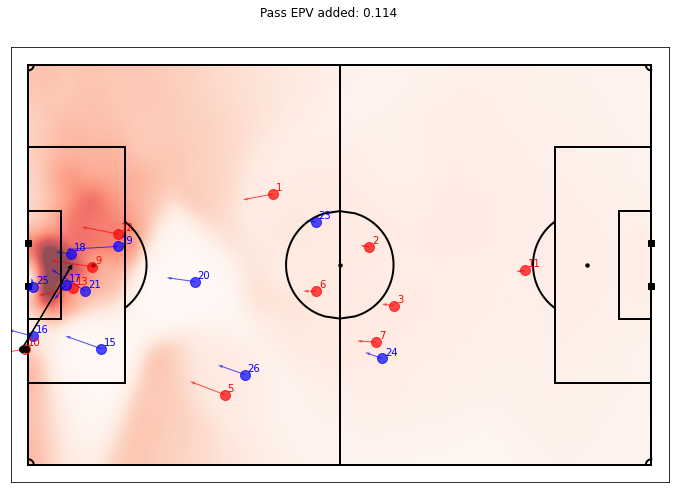

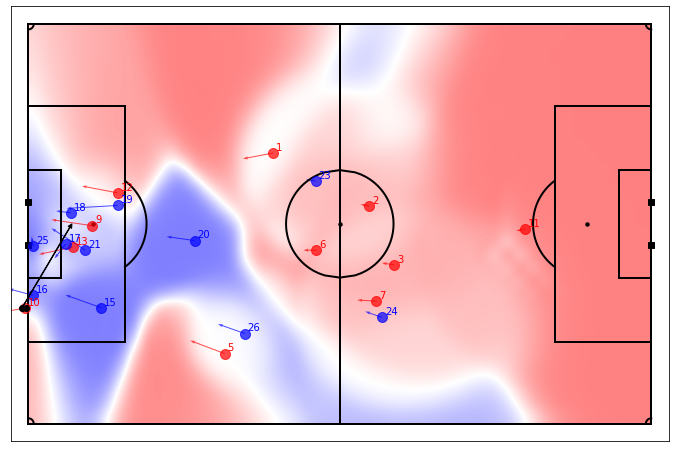

In [104]:
event_number = 1753
EEPV_added, EEPV_diff = calculate_epv_added(event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106., 68.), n_grid_cells_x = 50, offsides=True)
fig, ax = plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=True)
fig.suptitle(f"Pass EPV added: {EEPV_added:1.3f}", y=0.95)
plot_pitchcontrol_for_event(event_number, events, tracking_home, tracking_away, PPCF, annotate=True)


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

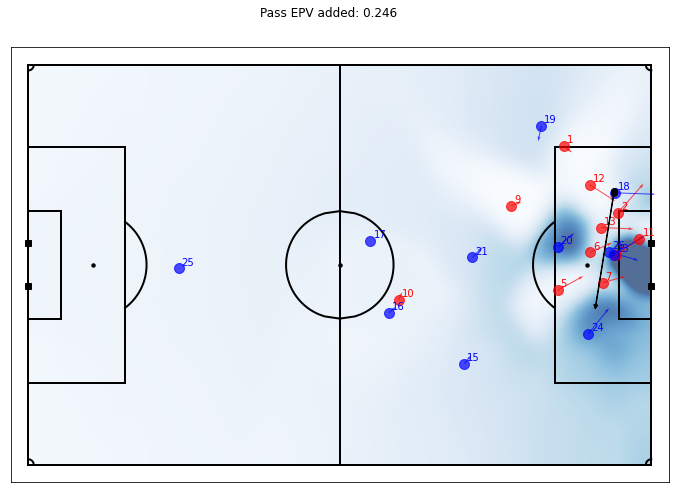

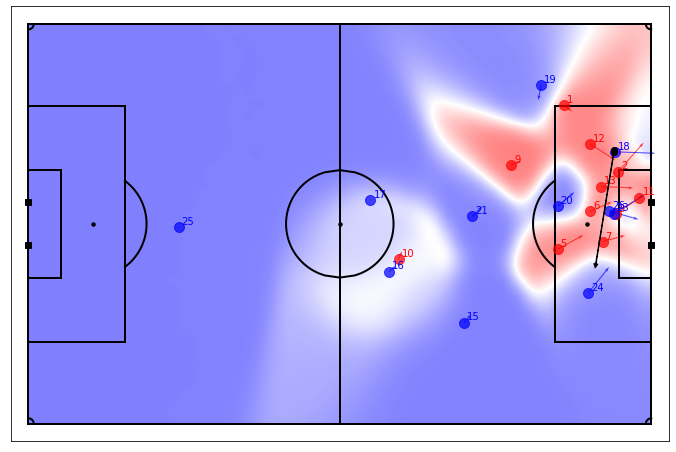

In [108]:
event_number = 1663
EEPV_added, EEPV_diff = calculate_epv_added(event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106., 68.), n_grid_cells_x = 50, offsides=True)
fig, ax = plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=True)
fig.suptitle(f"Pass EPV added: {EEPV_added:1.3f}", y=0.95)
plot_pitchcontrol_for_event(event_number, events, tracking_home, tracking_away, PPCF, annotate=True)

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

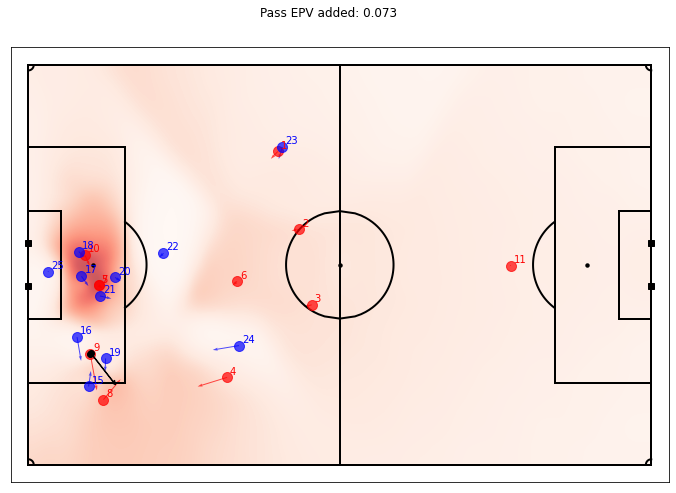

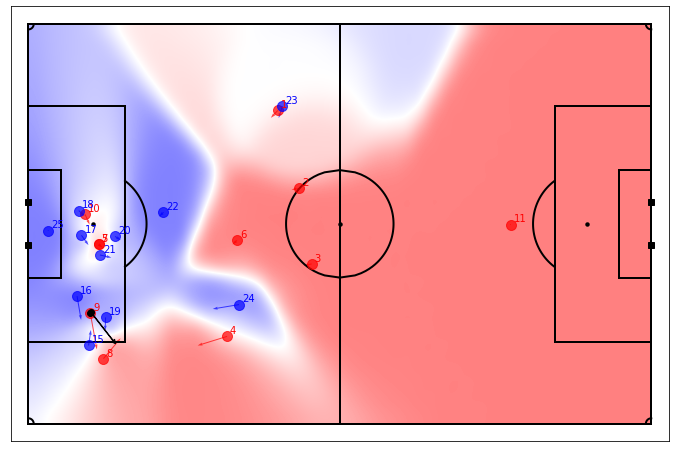

In [107]:
event_number = 195
EEPV_added, EEPV_diff = calculate_epv_added(event_number, events, tracking_home, tracking_away, GK_numbers, EPV, params)
PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106., 68.), n_grid_cells_x = 50, offsides=True)
fig, ax = plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=True)
fig.suptitle(f"Pass EPV added: {EEPV_added:1.3f}", y=0.95)
plot_pitchcontrol_for_event(event_number, events, tracking_home, tracking_away, PPCF, annotate=True)

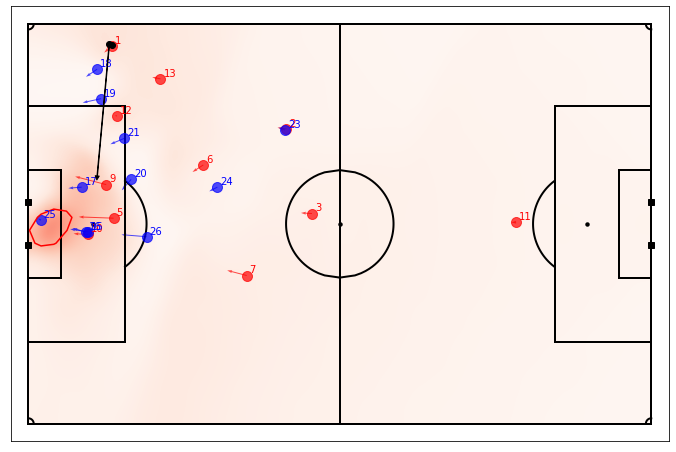

In [111]:
event_number = 1680
PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50, offsides=True)
fig, ax = plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True, contours=True)

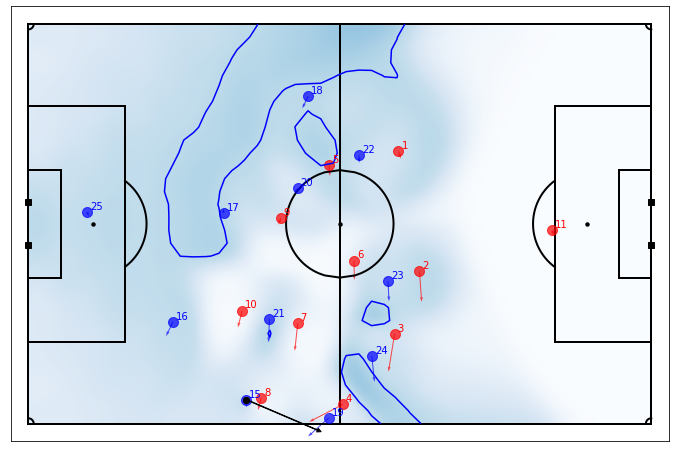

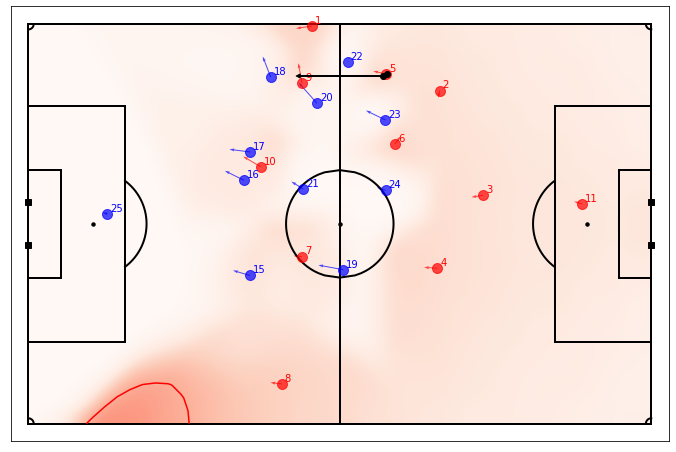

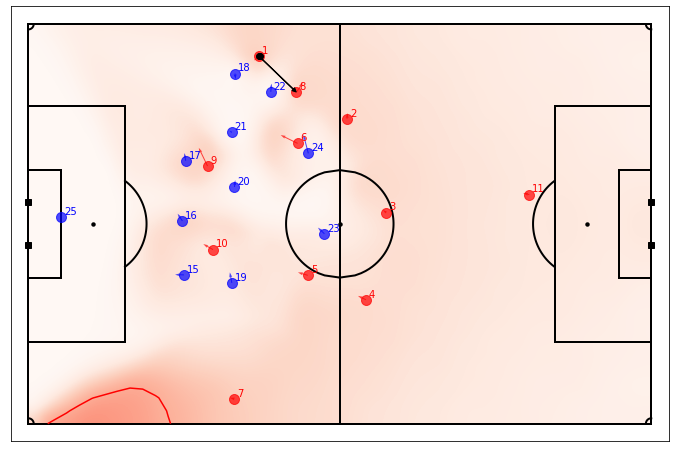

In [112]:
examples = [483, 68, 829]
for event_number in examples:
    PPCF, xgrid, ygrid = generate_pitch_control_for_event(event_number, events, tracking_home, tracking_away, params, GK_numbers, field_dimen=(106., 68.), n_grid_cells_x=50, offsides=True)
    fig, ax = plot_EPV_for_event(event_number, events, tracking_home, tracking_away, PPCF, EPV, annotate=True, autoscale=True, contours=True)